## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with analyzing the data, developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.



### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Please read the instructions carefully before starting the project.**

**Note**: If the free-tier GPU of Google Colab is not accessible (due to unavailability or exhaustion of daily limit or other reasons), the following steps can be taken:

1. Wait for 12-24 hours until the GPU is accessible again or the daily usage limits are reset.

2. Switch to a different Google account and resume working on the project from there.

3. Try using the CPU runtime:
    - To use the CPU runtime, click on *Runtime* => *Change runtime type* => *CPU* => *Save*
    - One can also click on the *Continue without GPU* option to switch to a CPU runtime (kindly refer to the snapshot below)
    - The instructions for running the code on the CPU are provided in the respective sections of the notebook.

## **Installing and Importing Necessary Libraries**

In [ ]:
#Vishwa Added
import sys
import os
import time
import numpy as np
# Importing the library for data manipulation
import pandas as pd

# to visualise data
import matplotlib.pyplot as plt
import seaborn as sns

#Vishwa - Need these imports for ML metrics calculations
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
# To import Word2Vec
from gensim.models import Word2Vec

# To tune the model
from sklearn.model_selection import GridSearchCV

# Converting the Stanford GloVe model vector format to word2vec
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
import torch
from sentence_transformers import SentenceTransformer

# to split data into train and test sets
from sklearn.model_selection import train_test_split
# to build a Random Forest model
from sklearn.ensemble import RandomForestClassifier
# to compute metrics to evaluate the model
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

In [ ]:

# installing libraries to use word embeddings
!pip install gensim -q
# installing the sentence-transformers and gensim libraries for word embeddings
!pip install -U sentence-transformers gensim transformers tqdm -q

# Ensure required NLTK data is downloaded
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

# to load the natural language toolkit
nltk.download('wordnet')    # loading the wordnet module that is used in stemming

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 77.7 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## **Loading the dataset**

In [ ]:
# loading the dataset
from google.colab import drive
drive.mount('/content/drive')
#VC Added
os.chdir("/content/drive/MyDrive")

Mounted at /content/drive


In [ ]:
#Read the file
data_original = pd.read_csv("stock_news.csv")

In [ ]:
data = data_original.copy()
# let's view a sample of the data
data.sample(n=10, random_state=42)

,Date,News,Open,High,Low,Close,Volume,Label
157,2019-01-30,Google and Facebook disenabled their research...,40.812500,41.537498,40.057499,39.939968,244439200,0
341,2019-04-30,"In early trading, U.S. stock futures were fla...",50.764999,50.849998,49.777500,48.708790,186139600,0
315,2019-04-17,"Facebook, aiming to compete with Alexa, Siri,...",49.884998,50.845001,49.652500,49.305897,115627200,-1
234,2019-03-14,The European Union's Competition Commissioner...,45.974998,46.025002,45.639999,44.596924,94318000,-1
155,2019-01-30,"Alibaba, the Chinese e-commerce giant and sec...",40.812500,41.537498,40.057499,39.939968,244439200,0
274,2019-03-26,Tesla's stock rose by 8.15% in premarket trad...,47.915001,48.220001,46.145000,45.339684,199202000,1
304,2019-04-12,"In this article, a Chinese-Taiwanese group le...",65.267502,65.827499,65.169998,64.211540,67181600,-1
227,2019-03-06,Fitbit introduced its most affordable smartwa...,43.900002,44.480000,42.567501,42.227238,161584400,0
278,2019-03-27,Lyft raised the price range for its IPO due t...,47.187500,47.439999,46.637501,45.747482,119393600,1
185,2019-02-12,Akamai Technologies reported stronger than pr...,66.817497,67.062500,65.862503,64.805229,94487200,1


## **Data Overview**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    349 non-null    object 
 1   News    349 non-null    object 
 2   Open    349 non-null    float64
 3   High    349 non-null    float64
 4   Low     349 non-null    float64
 5   Close   349 non-null    float64
 6   Volume  349 non-null    int64  
 7   Label   349 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 21.9+ KB




- Out of the 7 columns present in the dataset, 2 of them are objects while the other 6 of them are numerical in nature
- There are no missing values, since all the parameters have values
- There is a need to convert Date field into a 'Datetime' format



In [ ]:
# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

In [ ]:
# Drop rows with invalid dates
data = data.dropna(subset=['Date'])

# Sort data by Date
data = data.sort_values(by='Date')

In [ ]:
data.isnull().sum()
# let's check for missing values in the data
round(data.isnull().sum() / data.isnull().count() * 100, 2)

,0
Date,0.0
News,0.0
Open,0.0
High,0.0
Low,0.0
Close,0.0
Volume,0.0
Label,0.0


In [ ]:
# let's check for duplicate values in the data
data.duplicated().sum()

0

In [ ]:
data.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,349,2019-02-16 16:05:30.085959936,2019-01-02 00:00:00,2019-01-14 00:00:00,2019-02-05 00:00:00,2019-03-22 00:00:00,2019-04-30 00:00:00,NaN
Open,349.0,46.229233,37.567501,41.740002,45.974998,50.7075,66.817497,6.442817
High,349.0,46.700458,37.817501,42.244999,46.025002,50.849998,67.0625,6.507321
Low,349.0,45.745394,37.305,41.482498,45.639999,49.7775,65.862503,6.391976
Close,349.0,44.926317,36.254131,40.246914,44.596924,49.11079,64.805229,6.398338
Volume,349.0,128948236.103152,45448000.0,103272000.0,115627200.0,151125200.0,244439200.0,43170314.918964
Label,349.0,-0.054441,-1.0,-1.0,0.0,0.0,1.0,0.715119


In [ ]:
label_distribution = data['Label'].value_counts()
print(label_distribution)

Label
 0    170
-1     99
 1     80
Name: count, dtype: int64


Data Summary:

  Total rows: 349.
  - All columns are complete, with no missing values.
  - Date is successfully converted to datetime64[ns].(the formatted data)
  - The price range of all the stocks aggregated is in the range of  37 - 67 dollars
  - The volumes range from 45 million to around 2.4 billion trades

Sentiment Distribution:
  The sentiment distribution label, when examined has this distribution

  - Neutral (Label 0): 170 entries.
  - Negative (Label -1): 99 entries.
  - Positive  (Label 1): 80 entries.


Lets just observe the length of the entire news on the specific stocks

In [ ]:
data['news_length'] = data['News'].apply(lambda x: len(x.split(' ')))
data['news_length'].describe()

,news_length
count,349.000000
mean,49.312321
std,5.727770
min,19.000000
25%,46.000000
50%,50.000000
75%,53.000000
max,61.000000


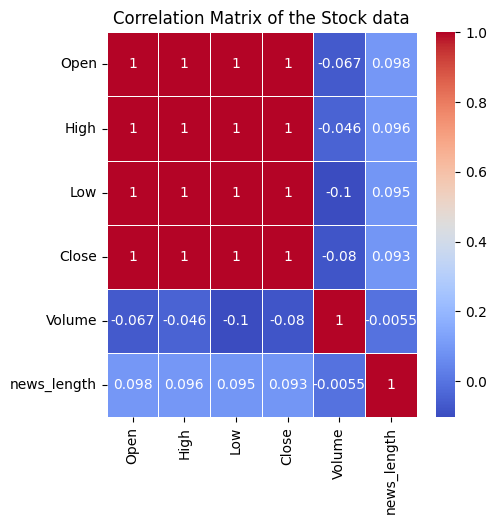

In [ ]:
columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'news_length']

# Compute the correlation matrix
correlation_matrix = data[columns].corr()
plt.figure(figsize=(5,5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of the Stock data')
plt.show()

 - There is minimal take away from the above correlation matrix except for one key aspect: Volume seems to be inversely correlated to 'Low' stock price(correlation is -0.1) This implies that if the stock price is hitting low, then the volumes have been high - owing to selling pressure. This makes perfect sense

###Data Cleansing and pre-processing

There could be a need to remove special characters, subsequently. Right now, we will only clean it and keep. We may or may not need this function

In [ ]:
import re

def clean_text(text):

    # Lowercase the text
    text = text.lower()

    # Remove punctuation and special characters
    pattern = '[^A-Za-z0-9\w\s+]'
    text = re.sub(pattern, '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply the cleaning function to the News column
data['Cleaned_News'] = data['News'].apply(clean_text)

# Preview the cleaned data
data[['News', 'Cleaned_News']].head(10)

,News,Cleaned_News
0,The tech sector experienced a significant dec...,the tech sector experienced a significant decl...
12,The dollar fell from above 109 to 106.67 afte...,the dollar fell from above 109 to 10667 after ...
11,"In early Asian trading on Thursday, the Japan...",in early asian trading on thursday the japanes...
10,The Australian dollar experienced significant...,the australian dollar experienced significant ...
9,Apple Inc. lowered its quarterly sales foreca...,apple inc lowered its quarterly sales forecast...
8,Apple's fiscal first quarter revenue came in ...,apples fiscal first quarter revenue came in be...
7,Wall Street saw modest gains on Wednesday but...,wall street saw modest gains on wednesday but ...
13,RBC Capital maintains its bullish stance on A...,rbc capital maintains its bullish stance on ap...
5,Apple CEO Tim Cook discussed the company's Q1 ...,apple ceo tim cook discussed the companys q1 w...
4,Apple's revenue warning led to a decline in U...,apples revenue warning led to a decline in usd...


In [ ]:
data.head()

,Date,News,Open,High,Low,Close,Volume,Label,news_length,Cleaned_News
0,2019-01-02,The tech sector experienced a significant dec...,41.740002,42.244999,41.482498,40.246914,130672400,-1,46,the tech sector experienced a significant decl...
12,2019-01-02,The dollar fell from above 109 to 106.67 afte...,41.740002,42.244999,41.482498,40.246914,130672400,-1,41,the dollar fell from above 109 to 10667 after ...
11,2019-01-02,"In early Asian trading on Thursday, the Japan...",41.740002,42.244999,41.482498,40.246914,130672400,-1,55,in early asian trading on thursday the japanes...
10,2019-01-02,The Australian dollar experienced significant...,41.740002,42.244999,41.482498,40.246914,130672400,0,43,the australian dollar experienced significant ...
9,2019-01-02,Apple Inc. lowered its quarterly sales foreca...,41.740002,42.244999,41.482498,40.246914,130672400,-1,48,apple inc lowered its quarterly sales forecast...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 349 entries, 0 to 348
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          349 non-null    datetime64[ns]
 1   News          349 non-null    object        
 2   Open          349 non-null    float64       
 3   High          349 non-null    float64       
 4   Low           349 non-null    float64       
 5   Close         349 non-null    float64       
 6   Volume        349 non-null    int64         
 7   Label         349 non-null    int64         
 8   news_length   349 non-null    int64         
 9   Cleaned_News  349 non-null    object        
dtypes: datetime64[ns](1), float64(4), int64(3), object(2)
memory usage: 30.0+ KB


## **Exploratory Data Analysis**

In [ ]:
# Lets map the sentiments to a more meaningful column
sentiment_mapping = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}
# Apply the mapping to the 'Label' column
data['Sentiment'] = data['Label'].map(sentiment_mapping)
# Check the updated DataFrame
print(data.head())

         Date                                               News       Open  \
0  2019-01-02   The tech sector experienced a significant dec...  41.740002   
12 2019-01-02   The dollar fell from above 109 to 106.67 afte...  41.740002   
11 2019-01-02   In early Asian trading on Thursday, the Japan...  41.740002   
10 2019-01-02   The Australian dollar experienced significant...  41.740002   
9  2019-01-02   Apple Inc. lowered its quarterly sales foreca...  41.740002   

         High        Low      Close     Volume  Label  news_length  \
0   42.244999  41.482498  40.246914  130672400     -1           46   
12  42.244999  41.482498  40.246914  130672400     -1           41   
11  42.244999  41.482498  40.246914  130672400     -1           55   
10  42.244999  41.482498  40.246914  130672400      0           43   
9   42.244999  41.482498  40.246914  130672400     -1           48   

                                         Cleaned_News Sentiment  
0   the tech sector experienced a sign

### Univariate Analysis

* Distribution of individual variables
* Compute and check the distribution of the length of news content

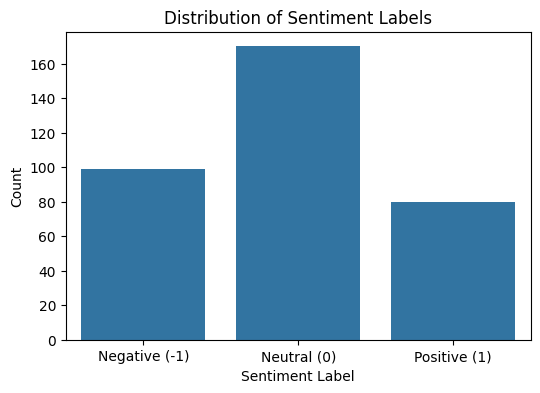

In [ ]:
# Plot the distribution of the Label column
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='Sentiment')
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=['Negative (-1)', 'Neutral (0)', 'Positive (1)'])
plt.show()

count    349.000000
mean     311.237822
std       39.079467
min      110.000000
25%      290.000000
50%      315.000000
75%      336.000000
max      394.000000
Name: News_Length, dtype: float64


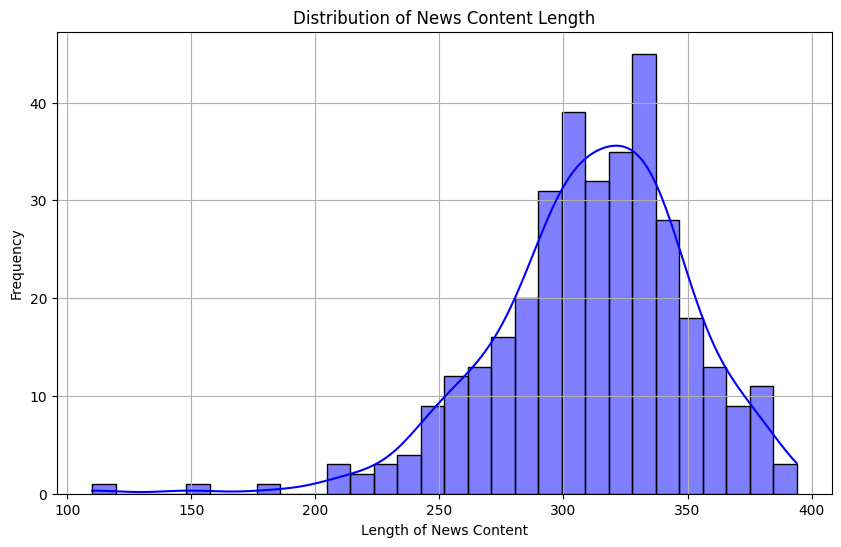

In [ ]:
data_cleaned = data.copy()
# Compute the length of each news article
data_cleaned['News_Length'] = data['News'].apply(len)

# Check basic statistics of the news lengths
print(data_cleaned['News_Length'].describe())

# Plot the distribution of news lengths
plt.figure(figsize=(10, 6))
sns.histplot(data_cleaned['News_Length'], bins=30, kde=True, color='blue')
plt.title('Distribution of News Content Length')
plt.xlabel('Length of News Content')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

- As we see the average length of new contents is about 302 letters, while the maximum is about 390.

<Axes: xlabel='Sentiment', ylabel='Volume'>

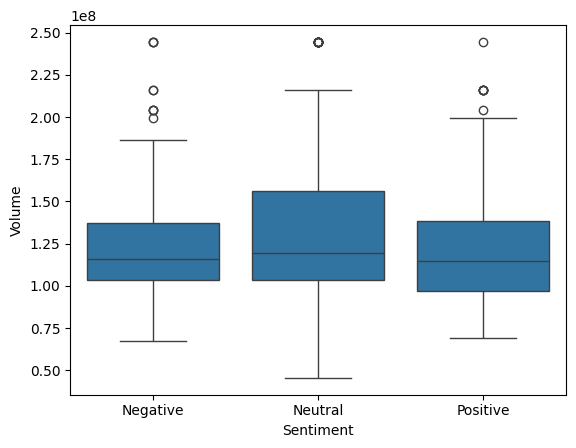

In [ ]:
sns.boxplot(data=data, x='Sentiment', y='Volume')

### Bivariate Analysis

* Correlation
* Sentiment Polarity vs Price
* Date vs Price

**Note**: The above points are listed to provide guidance on how to approach bivariate analysis. Analysis has to be done beyond the above listed points to get maximum scores.

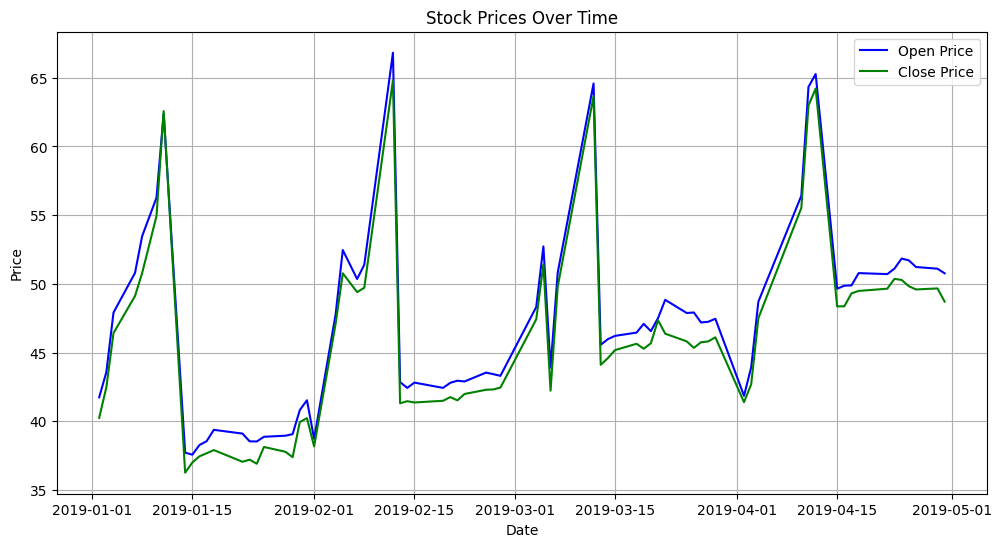

In [ ]:
# Plot Open and Close prices over time
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Open'], label='Open Price', color='blue')
plt.plot(data['Date'], data['Close'], label='Close Price', color='green')
plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## **Data Preprocessing**

## Word Embeddings

For Sentiment analysis, and to understand the data distribution across the months, lets analyze the aggregated words together.
Lets examine the column - 'Date' based on which we would know how the data is spread across various timelines

In [ ]:
data['Date'].describe()

,Date
count,349
mean,2019-02-16 16:05:30.085959936
min,2019-01-02 00:00:00
25%,2019-01-14 00:00:00
50%,2019-02-05 00:00:00
75%,2019-03-22 00:00:00
max,2019-04-30 00:00:00


 - What you see here is - 75% of the data is available on or before March 22, 2019, while the remaining 25% of the data is spread between 23 March till 30th April 2019.
 -Lets use this to split the data 75% Training and the rest of 25% as Test and Validation data

In [ ]:
X_train = data[data['Date'] < '2019-03-22'].reset_index()
X_val = data[(data['Date'] >= '2019-03-22') & (data['Date'] < '2019-04-08')].reset_index()
X_test = data[data['Date'] >= '2019-04-08'].reset_index()

In [ ]:
y_train = X_train['Label'].copy()
y_val = X_val['Label'].copy()
y_test = X_test['Label'].copy()

In [ ]:
# Check the shape of the splits
print(f'Training set shape: {X_train.shape}')
print(f'Validation set shape: {X_val.shape}')
print(f'Test set shape: {X_test.shape}')

# Check the shape of the splits
print(f'Training set shape: {y_train.shape}')
print(f'Validation set shape: {y_val.shape}')
print(f'Test set shape: {y_test.shape}')

Training set shape: (261, 12)
Validation set shape: (37, 12)
Test set shape: (51, 12)
Training set shape: (261,)
Validation set shape: (37,)
Test set shape: (51,)


In [ ]:
y_train.value_counts(normalize=True)

,proportion
Label,
0,0.482759
-1,0.287356
1,0.229885


In [ ]:
y_val.value_counts(normalize=True)

,proportion
Label,
0,0.540541
-1,0.243243
1,0.216216


- From the above , as expected the 'Neutral' values are high. The positive and negatives are low. Implying - not a good data set, OR a larger data set is the need of the hour.
- Anyway, this is what is given for the Project, So  - lets do it.

### **Word2Vec**

In [ ]:
# Creating a list of all words in our data
words_list = [item.split(" ") for item in data['News'].values]

In [ ]:
# Creating an instance of Word2Vec
vec_size = 300
model_W2V = Word2Vec(words_list, vector_size = vec_size, min_count = 1, window=5, workers = 6)

In [ ]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(list(model_W2V.wv.key_to_index)))

Length of the vocabulary is 4682


In [ ]:
# Checking the word embedding of a random word that has occured in our data sentence
word = "dollar"
model_W2V.wv[word]

array([-9.66295425e-04,  8.10583588e-03,  2.71035312e-03,  4.20741644e-03,
       -1.96872349e-03, -8.09151400e-03,  2.14304100e-03,  1.46425460e-02,
       -1.69049425e-03, -5.42324677e-04, -2.15111137e-03, -7.07559800e-03,
       -1.46519346e-03,  3.75627680e-03, -4.52057039e-03, -7.84996618e-03,
        5.55101363e-03, -5.35262702e-03,  8.59351130e-04,  7.28462997e-04,
       -8.02417938e-03, -2.12185085e-03,  4.11605416e-03,  3.13664204e-03,
        1.36038277e-03, -2.41535064e-03, -8.59868526e-03, -7.84990727e-04,
       -4.33377875e-03, -5.16076572e-03,  3.41433822e-03, -6.26679044e-03,
        3.97593016e-03, -1.97209930e-03,  1.84606807e-03,  2.26159650e-03,
        6.44994061e-03, -6.77466346e-03,  2.10434617e-03,  9.76462674e-04,
       -1.49057922e-03, -2.53371475e-03, -2.58634193e-03, -7.58522190e-03,
        3.36199300e-03,  6.95207948e-03,  2.80967681e-04,  6.38715830e-03,
        4.70743282e-04,  6.71440363e-03,  4.67723561e-03, -3.13650793e-03,
       -2.77909031e-03,  

In [ ]:
similar = model_W2V.wv.similar_by_word('price', topn=5)
print(similar)

[('and', 0.9957585334777832), ('The', 0.9956879615783691), ('in', 0.9956340789794922), ('to', 0.9955453276634216), ('of', 0.9955360889434814)]


In [ ]:
# Checking the word embedding of a random word that has occured in our data sentence
word = "trade"
model_W2V.wv[word]

array([-1.91026798e-03,  5.11329435e-02,  4.07551369e-03,  2.23701410e-02,
       -6.93993038e-03, -5.46033643e-02,  3.52183171e-02,  9.19724926e-02,
        1.14727588e-02, -1.28642051e-02,  3.81283625e-03, -2.54217107e-02,
       -9.19870276e-04,  1.46819856e-02, -3.89647186e-02, -3.25504392e-02,
        2.99940426e-02, -1.95621978e-02,  6.58892328e-03, -1.34373661e-02,
       -2.79487278e-02, -4.30232938e-03,  2.51951497e-02,  1.10626295e-02,
        3.22056152e-02, -3.40356259e-03, -4.06431220e-02,  7.57625734e-04,
       -2.74544526e-02, -4.64413352e-02,  5.65726869e-03, -2.81175859e-02,
        4.26205574e-03, -1.12634255e-02, -3.02159949e-03,  9.86707397e-03,
        3.03714387e-02, -3.91580984e-02, -6.74542086e-03, -8.63988418e-03,
       -1.82966162e-02, -3.65109742e-03,  6.47619134e-03, -3.23195234e-02,
        3.39248665e-02,  6.05711639e-02,  7.35985721e-03,  2.53528487e-02,
       -3.71034630e-03,  3.64113748e-02,  2.16146242e-02,  1.17469943e-04,
       -3.46178822e-02,  

Lets retrieve all the words present in the Word2Vec model's vocab

In [ ]:
# Retrieving the words present in the Word2Vec model's vocabulary
words = list(model_W2V.wv.key_to_index.keys())

# Retrieving word vectors for all the words present in the model's vocabulary
wvs = model_W2V.wv[words].tolist()

# Creating a dictionary of words and their corresponding vectors
word_vector_dict = dict(zip(words, wvs))

In [ ]:
def average_vectorizer_Word2Vec(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [ ]:
# creating a dataframe of the vectorized documents, seggragated for training validation and test documents
start = time.time()
X_train_wOfv = pd.DataFrame(X_train['News'].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature'+str(i) for i in range(vec_size)])
X_val_wOfv = pd.DataFrame(X_val['News'].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature'+str(i) for i in range(vec_size)])
X_test_wOfv = pd.DataFrame(X_test['News'].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature'+str(i) for i in range(vec_size)])
end = time.time()
print('Time consumed', end-start)

Time consumed 0.5286147594451904


In [ ]:
print(f'Training set shape: {X_train_wOfv.shape}')
print(f'Validation set shape: {X_val_wOfv.shape}')
print(f'Test set shape: {X_test_wOfv.shape}')

Training set shape: (261, 300)
Validation set shape: (37, 300)
Test set shape: (51, 300)


In [ ]:
df_Word2Vec = pd.DataFrame(data['News'].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
df_Word2Vec

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 290,Feature 291,Feature 292,Feature 293,Feature 294,Feature 295,Feature 296,Feature 297,Feature 298,Feature 299
0,0.001062,0.041921,0.004663,0.019299,-0.007793,-0.048813,0.028119,0.077468,0.008121,-0.008420,...,0.019237,0.044798,0.032846,-0.001706,0.036467,0.062447,0.013426,-0.021733,0.037416,-0.023587
1,0.000916,0.036085,0.004161,0.016333,-0.006377,-0.042400,0.024761,0.066965,0.007212,-0.007305,...,0.015758,0.039089,0.028331,-0.000831,0.031587,0.054522,0.011599,-0.018981,0.032158,-0.020536
2,0.000981,0.039957,0.004214,0.018772,-0.007128,-0.046143,0.026593,0.073157,0.007143,-0.007582,...,0.017426,0.042184,0.031106,-0.001172,0.034695,0.059451,0.013191,-0.020036,0.034779,-0.022077
3,0.000784,0.035729,0.004274,0.016864,-0.006601,-0.041894,0.024073,0.065708,0.006726,-0.006952,...,0.015687,0.038378,0.028122,-0.001103,0.031273,0.054222,0.011503,-0.017981,0.031476,-0.019886
4,0.000580,0.032568,0.003311,0.015146,-0.006131,-0.037396,0.021772,0.059140,0.006301,-0.006978,...,0.013772,0.033896,0.025439,-0.000960,0.027583,0.048094,0.010093,-0.016098,0.028324,-0.017829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,0.000749,0.027767,0.003254,0.013328,-0.005500,-0.032718,0.018986,0.051666,0.005663,-0.005440,...,0.012763,0.030023,0.022138,-0.001049,0.024202,0.041590,0.008797,-0.014076,0.024949,-0.015576
345,0.001000,0.028510,0.003306,0.013337,-0.004929,-0.032800,0.018871,0.052219,0.005293,-0.005740,...,0.012286,0.030397,0.022231,-0.000790,0.025027,0.042138,0.009246,-0.014100,0.025328,-0.016176
346,0.000618,0.025246,0.002524,0.011881,-0.004484,-0.029313,0.016870,0.046569,0.004937,-0.004657,...,0.010906,0.027201,0.020443,-0.000280,0.022171,0.037823,0.008177,-0.013129,0.022213,-0.014046
347,0.000543,0.031204,0.003461,0.014964,-0.005768,-0.036766,0.021235,0.058243,0.006167,-0.006780,...,0.014796,0.033760,0.024552,-0.000926,0.027180,0.047337,0.009972,-0.016205,0.027497,-0.017058


### **GloVe**

In [ ]:
# load the Stanford GloVe model
filename = 'glove.6B.100d.txt.word2vec'
glove_model = KeyedVectors.load_word2vec_format(filename, binary=False)

The size of the vector loaded is 100. Hence defining the size to be 100 here

In [ ]:
glove_vec_size = 100

In [ ]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(glove_model.index_to_key))

Length of the vocabulary is 399997


I had to delete few words in the file manually. Hence you see 3 words lesser, than the normal file size

In [ ]:
# Checking the word embedding of a random word
word = "trade"
glove_model[word]

array([ 0.37445 ,  0.2905  ,  0.52087 , -0.078068,  0.30331 , -1.6431  ,
       -0.55616 , -0.24898 ,  0.44383 , -0.99393 , -0.73201 , -0.79459 ,
        0.43296 ,  0.04844 ,  0.43213 ,  0.39854 ,  0.3002  , -0.36644 ,
       -0.71495 , -0.86286 ,  0.76708 ,  0.34937 ,  0.15718 ,  0.057662,
        0.56727 , -0.19785 ,  0.09236 , -0.94945 , -0.13466 , -0.052757,
       -0.82318 ,  0.68548 ,  0.07743 , -0.37814 , -0.39726 ,  0.12131 ,
        0.38462 , -0.43321 , -0.46539 , -0.07565 , -0.42237 , -1.1531  ,
        0.50071 ,  0.16092 ,  0.20233 , -0.57431 , -0.3286  , -0.095848,
       -0.35717 , -0.94171 ,  0.23192 ,  0.7344  , -0.49079 ,  0.59564 ,
       -0.28278 , -1.7117  , -0.44678 , -0.2318  ,  2.3063  ,  0.96044 ,
       -1.0516  , -0.26582 , -0.85635 , -0.44865 , -0.49    , -0.56414 ,
        0.49853 ,  0.14188 ,  0.97041 , -0.5719  ,  0.27742 , -0.46931 ,
       -0.30826 , -0.80948 , -0.25205 , -0.57841 , -0.97876 ,  0.035568,
       -1.5801  ,  0.41414 ,  0.67212 ,  0.79825 , 

In [ ]:
# Checking the word embedding of a random word
word = "price"
glove_model[word]

array([ 3.3108e-01,  1.9364e-01,  1.6607e-01,  8.6574e-02, -2.0639e-01,
       -1.4334e+00, -2.9923e-01, -1.1618e-01, -6.6627e-01, -1.4150e-01,
        2.1907e-01,  1.6721e-01, -1.6150e-01, -2.8570e-01,  2.7179e-01,
        9.5956e-02, -9.7168e-01,  1.0444e-01,  1.0485e-01,  1.3673e-01,
        8.3398e-01, -6.8866e-01,  2.6409e-01,  2.9890e-01,  5.9473e-01,
        1.4549e-02,  1.7850e-02, -9.5206e-01, -6.6171e-01, -2.2428e-01,
        3.2354e-01,  5.7278e-01, -7.1502e-02, -1.4367e-01,  3.1574e-01,
        7.4511e-01,  7.5837e-01, -1.7850e-03,  1.0807e-01, -9.9260e-01,
        2.5383e-01, -5.2487e-01, -1.3455e-01, -3.1672e-01,  3.7978e-02,
        4.0723e-01, -5.5722e-01, -1.0508e+00,  5.0940e-03, -1.4605e+00,
        8.2840e-01, -1.4003e-01, -9.2980e-03,  8.4426e-01, -2.6589e-01,
       -2.1714e+00, -5.7227e-02, -1.6759e-01,  2.0411e+00, -2.6865e-01,
        4.3311e-01, -4.7494e-01, -8.3282e-01,  4.2100e-01,  3.4240e-01,
       -5.1296e-01,  6.7027e-01, -2.9009e-01,  7.7592e-01, -1.89

In [ ]:
similar = glove_model.most_similar("price", topn=5)
print(similar)

[('prices', 0.8554712533950806), ('value', 0.760714054107666), ('drop', 0.7485076785087585), ('stock', 0.7451035380363464), ('market', 0.7407819628715515)]


In [ ]:
similar = glove_model.most_similar("trade", topn=5)
print(similar)

[('export', 0.7138485312461853), ('economic', 0.7101677060127258), ('trading', 0.7089402675628662), ('commerce', 0.7074280977249146), ('cooperation', 0.6854963302612305)]


In [ ]:
glove_model["trade"]

array([ 0.37445 ,  0.2905  ,  0.52087 , -0.078068,  0.30331 , -1.6431  ,
       -0.55616 , -0.24898 ,  0.44383 , -0.99393 , -0.73201 , -0.79459 ,
        0.43296 ,  0.04844 ,  0.43213 ,  0.39854 ,  0.3002  , -0.36644 ,
       -0.71495 , -0.86286 ,  0.76708 ,  0.34937 ,  0.15718 ,  0.057662,
        0.56727 , -0.19785 ,  0.09236 , -0.94945 , -0.13466 , -0.052757,
       -0.82318 ,  0.68548 ,  0.07743 , -0.37814 , -0.39726 ,  0.12131 ,
        0.38462 , -0.43321 , -0.46539 , -0.07565 , -0.42237 , -1.1531  ,
        0.50071 ,  0.16092 ,  0.20233 , -0.57431 , -0.3286  , -0.095848,
       -0.35717 , -0.94171 ,  0.23192 ,  0.7344  , -0.49079 ,  0.59564 ,
       -0.28278 , -1.7117  , -0.44678 , -0.2318  ,  2.3063  ,  0.96044 ,
       -1.0516  , -0.26582 , -0.85635 , -0.44865 , -0.49    , -0.56414 ,
        0.49853 ,  0.14188 ,  0.97041 , -0.5719  ,  0.27742 , -0.46931 ,
       -0.30826 , -0.80948 , -0.25205 , -0.57841 , -0.97876 ,  0.035568,
       -1.5801  ,  0.41414 ,  0.67212 ,  0.79825 , 

In [ ]:
# Retrieving the words present in the GloVe model's vocabulary
glove_words = glove_model.index_to_key

# Creating a dictionary of words and their corresponding vectors
glove_word_vector_dict = dict(zip(glove_model.index_to_key,list(glove_model.vectors)))

In [ ]:
# Checking the size of the word vectors
sample_word = next(iter(glove_word_vector_dict))  # Get any word from the dictionary
vector_size = len(glove_word_vector_dict[sample_word])
print(f"Size of each word vector: {vector_size}")

Size of each word vector: 100


In [ ]:
def average_vectorizer_GloVe(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((glove_vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in glove_words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(glove_word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [ ]:
# creating a dataframe of the vectorized documents, seggragated for training validation and test data
start = time.time()
X_train_Glove = pd.DataFrame(X_train['News'].apply(average_vectorizer_GloVe).tolist(), columns=['Feature'+str(i) for i in range(glove_vec_size)])
X_val_Glove = pd.DataFrame(X_val['News'].apply(average_vectorizer_GloVe).tolist(), columns=['Feature'+str(i) for i in range(glove_vec_size)])
X_test_Glove = pd.DataFrame(X_test['News'].apply(average_vectorizer_GloVe).tolist(), columns=['Feature'+str(i) for i in range(glove_vec_size)])
end = time.time()
print('Time consumed', end-start)

Time consumed 25.60692310333252


In [ ]:
# Check the shape of the splits
print(f'Training set shape: {X_train_Glove.shape}')
print(f'Validation set shape: {X_val_Glove.shape}')
print(f'Test set shape: {X_test_Glove.shape}')

Training set shape: (261, 100)
Validation set shape: (37, 100)
Test set shape: (51, 100)


Lets see how the training set looks like

In [ ]:
X_train_Glove

,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,...,Feature90,Feature91,Feature92,Feature93,Feature94,Feature95,Feature96,Feature97,Feature98,Feature99
0,-0.005744,0.065034,0.198916,-0.053848,0.107719,-0.286855,-0.224428,0.067162,-0.236218,0.081928,...,0.067063,0.031508,-0.376078,0.061713,-0.533375,0.040044,-0.072857,-0.161835,0.672949,-0.018650
1,0.332429,0.300881,0.301940,-0.020054,0.150397,-0.153267,-0.116960,0.013047,-0.357713,-0.035961,...,-0.169667,0.020875,-0.395804,0.032880,-0.675150,0.086899,0.061092,-0.115302,0.421511,0.067401
2,0.169846,0.136567,0.316959,0.089691,-0.005164,-0.351020,-0.252741,-0.048412,-0.294807,-0.031209,...,-0.016317,0.125821,-0.320011,0.213424,-0.488799,0.115904,0.054335,-0.126288,0.662260,-0.081259
3,-0.050593,0.193604,0.181146,0.076578,0.084979,-0.114077,-0.347261,-0.079555,-0.332893,0.043969,...,-0.047748,0.102322,-0.408408,0.188732,-0.401814,0.182035,-0.017142,-0.212770,0.500845,0.020391
4,0.050128,0.129402,0.359450,-0.095574,0.018255,-0.464786,-0.314391,0.017221,-0.173262,-0.021492,...,0.039273,0.152868,-0.210503,-0.159373,-0.631350,0.062505,0.077060,-0.175422,0.671941,0.041878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,0.040517,0.167622,0.171826,-0.053475,0.129755,-0.235215,-0.238100,-0.095288,-0.255113,-0.165047,...,-0.040647,-0.079401,-0.456793,0.099637,-0.504859,0.119006,-0.035386,-0.233737,0.539941,0.093500
257,0.118344,-0.013278,0.144002,-0.203889,0.441510,0.227652,-0.090245,0.068485,-0.066247,0.248138,...,-0.042649,-0.157951,-0.119621,0.033365,-0.133212,0.004129,-0.177454,-0.050751,0.697804,-0.033011
258,0.032381,0.139753,0.112855,-0.027904,0.176756,0.031614,-0.277453,0.163189,-0.123392,0.067757,...,-0.153687,-0.023271,-0.202407,-0.013650,-0.480210,-0.142024,-0.085066,-0.183361,0.726911,0.080275
259,0.256100,0.172381,0.260083,0.154866,0.162289,-0.133605,-0.052994,0.071577,-0.274533,-0.124852,...,-0.132325,0.188546,-0.400077,0.028262,-0.531506,0.095620,-0.081299,-0.172063,0.592162,0.042893


As expected, in the above you see 100 columns and 99 rows, as defined in the training data set

## **Sentiment Analysis**

Lets use Sentence Transformers as suggested. Lets load the same

In [ ]:
#Define the model with SentenceTransformer
model_st = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

###Dataset Encoding

In [ ]:
#Lets get gpu time. Hurray - we've purchased ColabPro, so we do expect GPU to be available
device_torch = torch.device("cuda")

We shall encode the dataset using Sentence Transformers we created above.

In [ ]:
start = time.time()
X_train_st = model_st.encode(X_train['News'].values, show_progress_bar=True, device=device_torch)
X_val_st = model_st.encode(X_val['News'].values, show_progress_bar=True, device=device_torch)
X_test_st = model_st.encode(X_test['News'].values, show_progress_bar=True, device=device_torch)
end = time.time()
print('Time taken : ', end-start)

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Time taken :  1.758087396621704


In [ ]:
# Check the shape of the splits
print(f'Training set shape: {X_train_st.shape}')
print(f'Validation set shape: {X_val_st.shape}')
print(f'Test set shape: {X_test_st.shape}')

Training set shape: (261, 384)
Validation set shape: (37, 384)
Test set shape: (51, 384)


The news column now has a reprentation in the form of a 384 dimensional vector

###Model Building

In [ ]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred, average='weighted')  # to compute Recall
    precision = precision_score(target, pred, average='weighted')  # to compute Precision
    f1 = f1_score(target, pred, average='weighted')  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf

In [ ]:
# creating a function to plot the confusion matrixdef plot_confusion_matrix(actual, predicted, labels):
# creating a function to plot the confusion matrix
def plot_confusion_matrix(actual, predicted, labels):
    # Convert to string to ensure type consistency
    actual = [str(a) for a in actual]
    predicted = [str(p) for p in predicted]

    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize = (5, 4))

    sns.heatmap(cm, annot = True,  fmt = '.0f',cmap='Blues', xticklabels = labels, yticklabels = labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

###Model Evaluation - Rationale
There is a need to build a model that classifies news into Positive, Negative and Neutral sentiments. Considering this, F1 seems to be a better suited parameter

- Its a conscious decision to use Random Forest model, although we will see if time permits, we could use other models as well

###Random Forest with Word2Vec

In [ ]:
#Building the model
rf_word2vec_base = RandomForestClassifier(n_estimators=75, max_depth=14, random_state = 42)

# Fitting on train data
rf_word2vec_base.fit(X_train_wOfv, y_train)

RandomForestClassifier(max_depth=14, n_estimators=75, random_state=42)

In [ ]:
print(f'Training set-X shape: {X_train_wOfv.shape}')
print(f'Training set-y shape: {y_train.shape}')

Training set-X shape: (261, 300)
Training set-y shape: (261,)


In [ ]:
# Predicting on train data
y_pred_train_base = rf_word2vec_base.predict(X_train_wOfv)

# Predicting on validation data
y_pred_val_base = rf_word2vec_base.predict(X_val_wOfv)

# Predicting on test data
y_pred_test_base = rf_word2vec_base.predict(X_test_wOfv)

In [ ]:
print(f'Training set shape: {y_pred_train_base.shape}')
print(f'Validation set shape: {y_pred_val_base.shape}')
print(f'Validation set shape: {y_pred_test_base.shape}')

Training set shape: (261,)
Validation set shape: (37,)
Validation set shape: (51,)


51 51


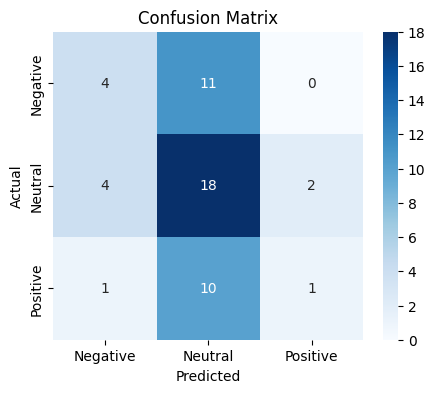

In [ ]:
# Example usage
labels = ['Negative', 'Neutral', 'Positive']  # Define the class labels explicitly
#plot_confusion_matrix(actual, predicted, labels)
print(len(y_test), len(y_pred_test_base))
plot_confusion_matrix(y_test, y_pred_test_base, labels)

In [ ]:
#Calculating different metrics on training data
word2vec_base_train = model_performance_classification_sklearn(rf_word2vec_base, X_train_wOfv, y_train)
print("Training performance:\n", word2vec_base_train)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [ ]:
#Calculating different metrics on validation data
word2vec_base_val = model_performance_classification_sklearn(rf_word2vec_base, X_val_wOfv,y_val)
print("Validation performance:\n", word2vec_base_val)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.486486  0.486486   0.400082  0.390988


In [ ]:
#Calculating different metrics on Test data
word2vec_base_test = model_performance_classification_sklearn(rf_word2vec_base, X_test_wOfv,y_test)
print("Testing performance:\n", word2vec_base_test)

Testing performance:
    Accuracy   Recall  Precision        F1
0   0.45098  0.45098   0.426345  0.398319


### Random Forest with GloVe

In [ ]:
# Building the model
rf_Glove_base = RandomForestClassifier(n_estimators=60, max_depth=12, random_state = 42)

# Fitting on train data
rf_Glove_base.fit(X_train_Glove, y_train)

RandomForestClassifier(max_depth=12, n_estimators=60, random_state=42)

In [ ]:
# Predicting on train data
y_pred_train_base = rf_Glove_base.predict(X_train_Glove)

# Predicting on test data
y_pred_test_base = rf_Glove_base.predict(X_test_Glove)

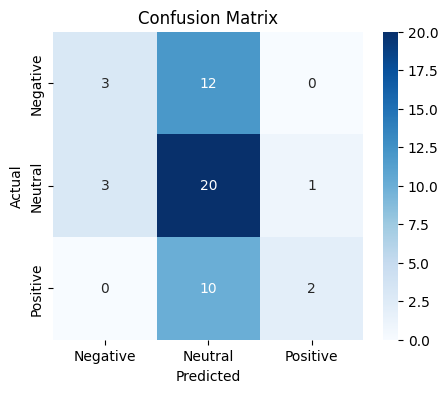

In [ ]:
#plot_confusion_matrix(actual, predicted, labels)
plot_confusion_matrix(y_test, y_pred_test_base, labels)

In [ ]:
#Calculating different metrics on training data
Glove_base_train=model_performance_classification_sklearn(rf_Glove_base, X_train_Glove, y_train)
print("Training performance:\n", Glove_base_train)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [ ]:
#Calculating different metrics on Validation data
Glove_base_val=model_performance_classification_sklearn(rf_Glove_base, X_val_Glove,y_val)
print("Testing performance:\n", Glove_base_val)

Testing performance:
    Accuracy    Recall  Precision        F1
0  0.486486  0.486486   0.565304  0.439802


In [ ]:
#Calculating different metrics on Test data
Glove_base_test=model_performance_classification_sklearn(rf_Glove_base, X_test_Glove,y_test)
print("Testing performance:\n", Glove_base_test)

Testing performance:
    Accuracy    Recall  Precision        F1
0  0.490196  0.490196   0.528011  0.431984


In [ ]:
# training performance comparison
models_train_comp_df = pd.concat(
    [word2vec_base_train.T,Glove_base_train.T],
    axis=1,
)
models_train_comp_df.columns = [
    "Word2vec - Base RF Model",
    "GloVe - Base RF Model"]
print("Training performance comparison:")

models_train_comp_df

Training performance comparison:


,Word2vec - Base RF Model,GloVe - Base RF Model
Accuracy,1.0,1.0
Recall,1.0,1.0
Precision,1.0,1.0
F1,1.0,1.0


In [ ]:
# training performance comparison
models_test_comp_df = pd.concat(
    [word2vec_base_test.T,Glove_base_test.T],
    axis=1,
)
models_train_comp_df.columns = [
    "Word2vec - Base RF Model",
    "GloVe - Base RF Model"]
print("Test performance comparison:")

models_test_comp_df

Test performance comparison:


,0,0
Accuracy,0.450980,0.490196
Recall,0.450980,0.490196
Precision,0.426345,0.528011
F1,0.398319,0.431984


###Random Forest with Sentence Transformer

In [ ]:
# Building the model
rf_SentTrans = RandomForestClassifier(n_estimators=60, max_depth=12, random_state = 42)

# Fitting on train data
rf_SentTrans.fit(X_train_st, y_train)

RandomForestClassifier(max_depth=12, n_estimators=60, random_state=42)

In [ ]:
# Predicting on train data
y_pred_train_base = rf_SentTrans.predict(X_train_st)

# Predicting on train data
y_pred_val_base = rf_SentTrans.predict(X_val_st)

# Predicting on test data
y_pred_test_base = rf_SentTrans.predict(X_test_st)

In [ ]:
#Calculating different metrics on training data
st_base_train=model_performance_classification_sklearn(rf_SentTrans, X_train_st, y_train)
print("Training performance:\n", st_base_train)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [ ]:
#Calculating different metrics on Validation data
st_base_val=model_performance_classification_sklearn(rf_SentTrans, X_val_st,y_val)
print("Testing performance:\n", st_base_val)

Testing performance:
    Accuracy    Recall  Precision        F1
0  0.459459  0.459459    0.42185  0.422147


In [ ]:
#Calculating different metrics on Validation data
st_base_test=model_performance_classification_sklearn(rf_SentTrans, X_test_st, y_test)
print("Testing performance:\n", st_base_test)

Testing performance:
    Accuracy    Recall  Precision        F1
0  0.470588  0.470588   0.493388  0.402517


## Tuned Model - With Word2Vec & Glove

###Word2Vec Tuned

In [ ]:
# Building the Word2Vec model
start = time.time()
rf_word2vec_Tuned = RandomForestClassifier(n_estimators=75, max_depth=14, random_state = 42)
parameters =  {
    'max_depth' : np.arange(3,7),
    'min_samples_split' : np.arange(5, 12, 2),
    'max_features' : ['log2', 'sqrt', 0.2, 0.4]
}

grid_container = GridSearchCV(rf_word2vec_Tuned, parameters, scoring = 'f1_weighted', cv=5, n_jobs=1)
grid_container = grid_container.fit(X_train_wOfv, y_train)

end = time.time()
print('Time taken', end-start)
#Setting the tuned model to the best estimator
rf_word2vec_Tuned = grid_container.best_estimator_

Time taken 104.51801323890686


In [ ]:
rf_word2vec_Tuned.fit(X_train_wOfv, y_train)

RandomForestClassifier(max_depth=5, max_features=0.2, min_samples_split=11,
                       n_estimators=75, random_state=42)

In [ ]:
#Calculating different metrics on training data
word2vec_tuned_train = model_performance_classification_sklearn(rf_word2vec_Tuned, X_train_wOfv, y_train)
print("Training performance:\n", word2vec_tuned_train)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.904215  0.904215   0.920073  0.903479


In [ ]:
word2vec_tuned_val = model_performance_classification_sklearn(rf_word2vec_Tuned, X_val_wOfv,y_val)
print("Validation performance:\n", word2vec_tuned_val)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.486486  0.486486   0.359541  0.387302


In [ ]:
#Calculating different metrics on Test data
word2vec_tuned_test = model_performance_classification_sklearn(rf_word2vec_Tuned, X_test_wOfv,y_test)
print("Testing performance:\n", word2vec_tuned_test)

Testing performance:
    Accuracy   Recall  Precision        F1
0   0.45098  0.45098   0.362745  0.322184


###Tuned Glove model

In [ ]:
# Building the Glove model
start = time.time()
rf_Glove_Tuned = RandomForestClassifier(n_estimators=75, max_depth=14, random_state = 42)
parameters =  {
    'max_depth' : np.arange(3,7),
    'min_samples_split' : np.arange(5, 12, 2),
    'max_features' : ['log2', 'sqrt', 0.2, 0.4]
}

grid_container = GridSearchCV(rf_Glove_Tuned, parameters, scoring = 'f1_weighted', cv=5, n_jobs=1)
grid_container = grid_container.fit(X_train_wOfv, y_train)

end = time.time()
print('Time taken', end-start)
#Setting the tuned model to the best estimator
rf_Glove_Tuned = grid_container.best_estimator_

Time taken 104.86219692230225


In [ ]:
# Fitting on train data
rf_Glove_Tuned.fit(X_train_Glove, y_train)

RandomForestClassifier(max_depth=6, max_features=0.2, min_samples_split=5,
                       n_estimators=75, random_state=42)

In [ ]:
#Calculating different metrics on training data
Glove_tuned_train = model_performance_classification_sklearn(rf_Glove_Tuned, X_train_Glove, y_train)
print("Training performance:\n", Glove_tuned_train)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.984674  0.984674    0.98489  0.984638


In [ ]:
Glove_tuned_val = model_performance_classification_sklearn(rf_Glove_Tuned, X_val_Glove,y_val)
print("Validation performance:\n", Glove_tuned_val)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.567568  0.567568   0.637332  0.514333


In [ ]:
#Calculating different metrics on Test data
Glove_tuned_test = model_performance_classification_sklearn(rf_Glove_Tuned, X_test_Glove,y_test)
print("Testing performance:\n", Glove_tuned_test)

Testing performance:
    Accuracy    Recall  Precision        F1
0  0.490196  0.490196    0.48366  0.445288


###Tuned Sentence Transformer with RF Model

In [ ]:
# Building the sentence Xformer model
start = time.time()
rf_SentTrans = RandomForestClassifier(n_estimators=60, max_depth=12, random_state = 42)

parameters =  {
    'max_depth' : np.arange(3,7),
    'min_samples_split' : np.arange(5, 12, 2),
    'max_features' : ['log2', 'sqrt', 0.2, 0.4]
}

grid_container = GridSearchCV(rf_SentTrans, parameters, scoring = 'f1_weighted', cv=5, n_jobs=1)

grid_container = grid_container.fit(X_train_wOfv, y_train)
end = time.time()
print('Time taken', end-start)
#Setting the tuned model to the best estimator
rf_SentTrans = grid_container.best_estimator_

Time taken 84.07572317123413


In [ ]:
# Fitting on train data
rf_SentTrans.fit(X_train_st, y_train)

RandomForestClassifier(max_depth=6, max_features=0.4, min_samples_split=7,
                       n_estimators=60, random_state=42)

In [ ]:
#Calculating different metrics on training data
st_tuned_train = model_performance_classification_sklearn(rf_SentTrans, X_train_st, y_train)
print("Training performance:\n", st_base_train)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [ ]:
st_tuned_val = model_performance_classification_sklearn(rf_SentTrans, X_val_st,y_val)
print("Validation performance:\n", st_base_val)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.459459  0.459459    0.42185  0.422147


In [ ]:
#Calculating different metrics on Test data
st_tuned_test = model_performance_classification_sklearn(rf_SentTrans, X_test_st,y_test)
print("Testing performance:\n", st_base_test)

Testing performance:
    Accuracy    Recall  Precision        F1
0  0.470588  0.470588   0.493388  0.402517


###Model Summary and comparisons

In [ ]:
# training performance comparison
models_train_comp_df = pd.concat(
    [word2vec_base_train.T,
     Glove_base_train.T,
     st_base_train.T,
     word2vec_tuned_train.T,
     Glove_tuned_train.T,
     st_tuned_train.T,],
    axis=1,
)
models_train_comp_df.columns = [
    "Word2vec - Base RF Model",
    "GloVe - Base RF Model",
    "Sent Xformer - Base RF Model",
    "Word2vec - Tuned RF Model",
    "GloVe - Tuned RF Model",
    "Sent Xformer - Tuned ST Model"]
print("Training performance comparison:")

models_train_comp_df

Training performance comparison:


,Word2vec - Base RF Model,GloVe - Base RF Model,Sent Xformer - Base RF Model,Word2vec - Tuned RF Model,GloVe - Tuned RF Model,Sent Xformer - Tuned ST Model
Accuracy,1.0,1.0,1.0,0.980843,0.984674,1.0
Recall,1.0,1.0,1.0,0.980843,0.984674,1.0
Precision,1.0,1.0,1.0,0.981574,0.984890,1.0
F1,1.0,1.0,1.0,0.980803,0.984638,1.0


In [ ]:
# validation performance comparison
models_val_comp_df = pd.concat(
    [word2vec_base_val.T,
     Glove_base_val.T,
     st_base_val.T,
     word2vec_tuned_val.T,
     Glove_tuned_val.T,
     st_tuned_val.T,],
    axis=1,
)
models_val_comp_df.columns = [
    "Word2vec - Base RF Model",
    "GloVe - Base RF Model",
    "Sent Xformer - Base RF Model",
    "Word2vec - Tuned RF Model",
    "GloVe - Tuned RF Model",
    "Sent Xformer - Tuned ST Model"]
print("Validation performance comparison:")

models_val_comp_df

Validation performance comparison:


,Word2vec - Base RF Model,GloVe - Base RF Model,Sent Xformer - Base RF Model,Word2vec - Tuned RF Model,GloVe - Tuned RF Model,Sent Xformer - Tuned ST Model
Accuracy,0.486486,0.486486,0.459459,0.432432,0.567568,0.486486
Recall,0.486486,0.486486,0.459459,0.432432,0.567568,0.486486
Precision,0.447908,0.565304,0.421850,0.262080,0.637332,0.359541
F1,0.419828,0.439802,0.422147,0.326364,0.514333,0.387302


###Inferences on the selected Model and showcase the Model performance with Test Data
 - As we see all the models do overfit

In [ ]:
# testing performance comparison
models_test_comp_df = pd.concat(
    [word2vec_base_test.T,
     Glove_base_test.T,
     st_base_test.T,
     word2vec_tuned_test.T,
     Glove_tuned_test.T,
     st_tuned_test.T,],
    axis=1,
)
models_test_comp_df.columns = [
    "Word2vec - Base RF Model",
    "GloVe - Base RF Model",
    "Sent Xformer Model",
    "Word2vec - Tuned RF Model",
    "GloVe - Tuned RF Model",
    "Sent Xformer - Tuned ST Model"]
print("Testing performance comparison:")

models_test_comp_df

Testing performance comparison:


,Word2vec - Base RF Model,GloVe - Base RF Model,Sent Xformer Model,Word2vec - Tuned RF Model,GloVe - Tuned RF Model,Sent Xformer - Tuned ST Model
Accuracy,0.450980,0.490196,0.470588,0.431373,0.490196,0.509804
Recall,0.450980,0.490196,0.470588,0.431373,0.490196,0.509804
Precision,0.361893,0.528011,0.493388,0.423621,0.483660,0.661660
F1,0.344272,0.431984,0.402517,0.356537,0.445288,0.406447


###Chosen Model

- As we see from the above three model comparisons of base models with Fine tuned models, the Glove model seems to be performing slightly better than the rest.
- The best amongst the average performance across all models. We decide to go with Glove-Tuned RF Model with Test F1 score of .445
- The validation score of this Tuned RF model being slightly better at .514

## **Weekly News Summarization**

**Important Note**: It is recommended to run this section of the project independently from the previous sections in order to avoid runtime crashes due to RAM overload.

#### Installing and Importing the necessary libraries

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
# Installation for GPU llama-cpp-python
# uncomment and run the following code in case GPU is being used
!CMAKE_ARGS="-DGGML_CUDA=on" pip install llama-cpp-python -q
#!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python --force-reinstall --no-cache-dir --verbose


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 MB 34.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.7 MB/s eta 0:00:00


In [ ]:
#!pip install transformers datasets torch -q
# Function to download the model from the Hugging Face model hub
from huggingface_hub import hf_hub_download

# Importing the Llama class from the llama_cpp module
from llama_cpp import Llama

from tqdm import tqdm # For progress bar related functionalities
tqdm.pandas()

In [ ]:
from huggingface_hub import snapshot_download
from huggingface_hub import HfApi, HfFolder

# Replace 'your_huggingface_token' with your actual token
huggingface_token = "zya"

# Save the token to the local Hugging Face configuration
HfFolder.save_token(huggingface_token)

# Verify authentication by listing your models (optional)
api = HfApi()
user_info = api.whoami()
print(f"Authenticated as: {user_info['name']}")

Authenticated as: VISHWAVASU


In [ ]:
# Specify the model name
model_name = "TheBloke/Mistral-7B-Instruct-v0.2-GGUF"
model_base= "mistral-7b-instruct-v0.2.Q6_K.gguf"

# Path to the GGUF model file
local_dir_path = "/content/drive/MyDrive/mistral-7b"
gguf_model_path = f"{local_dir_path}/mistral-7b-instruct-v0.2.Q6_K.gguf"

# Load the GGUF model using Llama
llm_model = Llama(model_path=gguf_model_path, n_gpu_layers=100, n_ctx=4500)

print("Model loaded successfully!")


ggml_cuda_init: GGML_CUDA_FORCE_MMQ:    no
ggml_cuda_init: GGML_CUDA_FORCE_CUBLAS: no
ggml_cuda_init: found 1 CUDA devices:
  Device 0: Tesla T4, compute capability 7.5, VMM: yes
llama_model_load_from_file: using device CUDA0 (Tesla T4) - 14771 MiB free
llama_model_loader: loaded meta data with 24 key-value pairs and 291 tensors from /content/drive/MyDrive/mistral-7b/mistral-7b-instruct-v0.2.Q6_K.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.2
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                     

Model loaded successfully!


CUDA : ARCHS = 750 | USE_GRAPHS = 1 | PEER_MAX_BATCH_SIZE = 128 | CPU : SSE3 = 1 | SSSE3 = 1 | AVX = 1 | AVX2 = 1 | F16C = 1 | FMA = 1 | LLAMAFILE = 1 | OPENMP = 1 | AARCH64_REPACK = 1 | 
Model metadata: {'tokenizer.chat_template': "{{ bos_token }}{% for message in messages %}{% if (message['role'] == 'user') != (loop.index0 % 2 == 0) %}{{ raise_exception('Conversation roles must alternate user/assistant/user/assistant/...') }}{% endif %}{% if message['role'] == 'user' %}{{ '[INST] ' + message['content'] + ' [/INST]' }}{% elif message['role'] == 'assistant' %}{{ message['content'] + eos_token}}{% else %}{{ raise_exception('Only user and assistant roles are supported!') }}{% endif %}{% endfor %}", 'tokenizer.ggml.add_eos_token': 'false', 'tokenizer.ggml.padding_token_id': '0', 'tokenizer.ggml.unknown_token_id': '0', 'tokenizer.ggml.eos_token_id': '2', 'general.architecture': 'llama', 'llama.rope.freq_base': '1000000.000000', 'llama.context_length': '32768', 'general.name': 'mistralai_mi

In [ ]:
print("Local path of mistral model being - ",local_dir_path)

Local path of mistral model being -  /content/drive/MyDrive/mistral-7b


In [ ]:
# Generate text using the model
prompt = "Once upon a time, there was this beautiful girl who was roaming in the forest."

response = llm_model(prompt)
print(response['choices'][0]['text'])

Llama.generate: 8 prefix-match hit, remaining 11 prompt tokens to eval
llama_perf_context_print:        load time =     229.19 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    11 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    15 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     753.81 ms /    26 tokens


 She was wearing a red saree and had long black hair. She had


A quick validation of the llama model is complete

## Model Loading for Summarization - Hugging Face

##### Utility Functions - Recommended Code

Following is the utility extract function suggested by the program and lets use the same

In [ ]:
# defining a function to parse the JSON output from the model
def extract_json_data(json_str):
    import json
    try:
        # Find the indices of the opening and closing curly braces
        json_start = json_str.find('{')
        json_end = json_str.rfind('}')

        if json_start != -1 and json_end != -1:
            extracted_category = json_str[json_start:json_end + 1]  # Extract the JSON object
            data_dict = json.loads(extracted_category)
            return data_dict
        else:
            print(f"Warning: JSON object not found in response: {json_str}")
            return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

####Weekly Data Aggregation- Recommended code

In [ ]:
data["Date"] = pd.to_datetime(data['Date'])  # Convert the 'Date' column to datetime format.
# Group the data by week using the 'Date' column.
weekly_grouped = data.groupby(pd.Grouper(key='Date', freq='W'))
weekly_grouped = weekly_grouped.agg(
    {
        'News': lambda x: ' || '.join(x)  # Join the news values with ' || ' separator.
    }
).reset_index()

print(weekly_grouped.shape)

(18, 2)


In [ ]:
weekly_grouped.head(10)

,Date,News
0,2019-01-06,The tech sector experienced a significant dec...
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...
2,2019-01-20,U.S. stocks declined after the close on Monda...
3,2019-01-27,The White House reportedly rejected a schedul...
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...
5,2019-02-10,"Despite strong January market performance, fe..."
6,2019-02-17,"Japan Display Inc, an ailing Apple supplier, ..."
7,2019-02-24,This news article discusses progress towards ...
8,2019-03-03,"Huawei, the world's third-largest smartphone ..."
9,2019-03-10,"Spotify, the world's largest paid music strea..."


In [ ]:
#Replicate the weekly date
data_grouped_week = weekly_grouped.copy()

#### Defining the response function - Recommended template

In [ ]:
#Defining the response function
def response_mistral_1(prompt, news):
    model_output = llm_model(
      f"""
      [INST]
      {prompt}
      News Articles: {news}
      [/INST]
      """,
      max_tokens=500, #Complete the code to set the maximum number of tokens the model should generate for this task.
      temperature=0.7, #Complete the code to set the value for temperature.
      top_p=0.9, #Complete the code to set the value for top_p
      top_k=50, #Complete the code to set the value for top_k
      echo=False,
    )

    final_output = model_output["choices"][0]["text"]

    return final_output

####Model Evaluation : Checking the model output on a sample


In [ ]:
##################Working with the Model-1############################
prompt = "Please summarize the key points from the following article"
news = """The global economy has been experiencing significant shifts in the past year.
Many countries have adopted stimulus measures to mitigate the effects of the pandemic,
while others are facing challenges related to inflation and unemployment.
Experts predict that the economy may take several years to fully recover.
"""
# Call the response function
output = response_mistral_1(prompt, news)

# Print the generated response
print("Generated Response:")
print(output)

###################Working with the model ##############################

Llama.generate: 1 prefix-match hit, remaining 90 prompt tokens to eval
llama_perf_context_print:        load time =     229.19 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    90 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    86 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    4366.57 ms /   176 tokens


Generated Response:
1. The global economy has undergone notable changes in the last year.
2. Numerous countries have implemented stimulus packages to cushion their economies from the pandemic's impact.
3. Some economies, however, are grappling with challenges such as inflation and unemployment.
4. Economists anticipate that the economy will take several years to return to its pre-pandemic state.


In [ ]:
##################Working with the Model-2############################
prompt = """You are an expert in stock market news aggregation.
You shall be given multiple news articles, each separater by '||'.
Read through each of the news article and extract the top 3 positive and negative news, that are going to impact the stock's performance. Consider market trends, companies performance, along with market sentiments about the particular company
Return a JSON format in the following way:
{"Positive factors impacting" :[point-1, point-2, point-3]}, "Negative factors impacting" :[point-1, point-2, point-3]
Return only JSON output. I dont want anything else"
"""
news = data['News'].iloc[23]
start = time.time()
summarynews = response_mistral_1(prompt, news)
end = time.time()
print("time taken", end-start)

# Print the generated response
summarynews

###################Working with the model ##############################

Llama.generate: 115 prefix-match hit, remaining 119 prompt tokens to eval
llama_perf_context_print:        load time =     229.19 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   119 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   205 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   10665.58 ms /   324 tokens


time taken 10.673004865646362


' {"Negative factors impacting" :["Lower-than-expected fourth quarter unit revenue growth", "Weaker than anticipated late bookings", "Increased competition"],\n        "Positive factors impacting" :[]}\n\n       If there are positive factors mentioned in the news articles, they would be added to the "Positive factors impacting" array. For instance:\n\n       News Articles: Delta Air Lines Inc reported better-than-expected fourth quarter earnings, with profits rising 12% year-over-year. The company also announced plans to repurchase $1 billion in shares, which is a positive sign for shareholders. Fuel prices, however, are expected to remain a headwind for the airline.\n\n       {"Negative factors impacting" :["Fuel prices"],\n        "Positive factors impacting" :["Better-than-expected fourth quarter earnings", "Plans to repurchase $1 billion in shares"]}'

In [ ]:
##################Working with the Model - 3############################
prompt = """You are an expert stock market analyst. You are given many news articles separated by '||' symbol. Read through each of the news articles, and extract the top 3 positive and negative news, that potentially would impact the stock market's performance. Corraborate the news with company's Quarterly performance, the sector trends.
Return a JSON format in the following way:
{"Positive factors impacting" :[point-1, point-2, point-3]}, "Negative factors impacting" :[point-1, point-2, point-3]
Return only JSON output. Nothing else"
"""
news = data['News'].iloc[19]
start = time.time()
summarynews = response_mistral_1(prompt, news)
end = time.time()
print("time taken", end-start)

# Print the generated response
summarynews

###################Working with the model ##############################

Llama.generate: 13 prefix-match hit, remaining 214 prompt tokens to eval
llama_perf_context_print:        load time =     229.19 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   214 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   145 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    7880.04 ms /   359 tokens


time taken 7.88718581199646


' {"Positive factors impacting": ["OPEC\'s production cuts", "Gains in US WTI and Brent crude"],\n        "Negative factors impacting": ["Volatility in stock markets", "Apple\'s lowered revenue forecast", "Global economic slowdown fears"]}\n\n       Note: The impact of shale production on the oil market is not explicitly stated as positive or negative in the given news article. Therefore, it has not been included in the JSON output. However, it could potentially be a negative factor if it contributes to oversupply and downward pressure on oil prices. This would depend on the specific context and details of the shale production situation.'

Now let us check the model's performance on the weekly data that we had grouped.
Lets use weekly_grouped data to extract news of the 13th week.

In [ ]:
news = weekly_grouped['News'].iloc[13]
start = time.time()
summarynews = response_mistral_1(prompt, news)
end = time.time()
print("time taken", end-start)

# Print the generated response
summarynews

Llama.generate: 149 prefix-match hit, remaining 870 prompt tokens to eval
llama_perf_context_print:        load time =     229.19 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   870 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   192 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   11584.00 ms /  1062 tokens


time taken 11.594954252243042


'{"Positive factors impacting": [\n        "Apple and other consumer brands reduced prices in China following a tax rate cut, benefiting companies like Apple and Swatch Group.",\n        "Swatch Group successfully defended its use of the \'Tick different\' slogan against Apple\'s trademark infringement claim.",\n        "S&P 500, Dow Jones Industrial Average, and Nasdaq Composite closed higher due to optimism over US-China trade talks and surging chip stocks."\n      ],\n      "Negative factors impacting": [\n        "Apple suffered pre-market losses due to price cuts in China.",\n        "Samsung Electronics faces challenges including falling memory chip prices and slowing demand for display panels, potentially leading to earnings miss.",\n        "Boeing suffered pre-market losses due to a software update delay."\n      ]\n     }'

####Weekly Data Structure

Lets check on the entire weekly data structure that contains data from 18 weeks, from the given stock_news data to the project

In [ ]:
start = time.time()
weekly_grouped['Key Events'] = weekly_grouped['News'].progress_apply(lambda x: response_mistral_1(prompt, x))
end = time.time()
print("Time taken", end-start)

  0%|          | 0/18 [00:00<?, ?it/s]Llama.generate: 149 prefix-match hit, remaining 3745 prompt tokens to eval
llama_perf_context_print:        load time =     229.19 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  3745 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   175 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   13845.58 ms /  3920 tokens
 11%|█         | 2/18 [00:13<01:50,  6.94s/it]Llama.generate: 149 prefix-match hit, remaining 2234 prompt tokens to eval
llama_perf_context_print:        load time =     229.19 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  2234 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   236 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   15865.21 ms /  2470 tok

Time taken 262.49133014678955


In [ ]:
weekly_grouped['Key Events'].head(8)

,Key Events
0,"{""Positive factors impacting"": [],\n ""N..."
1,"{""Positive factors impacting"": [\n ""S..."
2,"{""Positive factors impacting"": [\n ""D..."
3,"{""Positive factors impacting"": [\n ""Tom..."
4,"{""Positive factors impacting"": [\n ""Ap..."
5,"{""Positive factors impacting"": [\n ""R..."
6,"{""Positive factors impacting"": [\n ""Ja..."
7,"{""Positive factors impacting"": [\n ""..."


While the model seems to have given the text I need, it needs better structural formatting

In [ ]:
weekly_grouped['formatted_response'] = weekly_grouped['Key Events'].apply(extract_json_data)
weekly_grouped.head()

,Date,News,Key Events,formatted_response
0,2019-01-06,The tech sector experienced a significant dec...,"{""Positive factors impacting"": [],\n ""N...","{'Positive factors impacting': [], 'Negative f..."
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...,"{""Positive factors impacting"": [\n ""S...",{'Positive factors impacting': ['Sprint and Sa...
2,2019-01-20,U.S. stocks declined after the close on Monda...,"{""Positive factors impacting"": [\n ""D...",{'Positive factors impacting': ['Dialog Semico...
3,2019-01-27,The White House reportedly rejected a schedul...,"{""Positive factors impacting"": [\n ""Tom...",{'Positive factors impacting': ['TomTom agrees...
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...,"{""Positive factors impacting"": [\n ""Ap...",{'Positive factors impacting': ['Apple reporte...


In [ ]:
model_response_parsed = pd.json_normalize(weekly_grouped['formatted_response'])
model_response_parsed.head()

,Positive factors impacting,Negative factors impacting
0,[],[Apple's Q1 revenue warning attributed to weak...
1,[Sprint and Samsung's plan to release 5G smart...,[Deutsche Bank's identification of potential s...
2,[Dialog Semiconductor reported resilient fourt...,[U.S. stocks declined after the close on Monda...
3,[TomTom agrees to sell fleet management busine...,[White House rejects scheduled meeting with Ch...
4,[Apple reported stronger-than-expected earning...,[Caterpillar reported lower-than-expected four...


In [ ]:
Summary_output = pd.concat([weekly_grouped.reset_index(drop=True), model_response_parsed], axis=1)
Summary_output.drop(['Key Events', 'formatted_response'], axis=1, inplace=True)
Summary_output.columns = ['Week End date', 'News', 'Week Positive events', 'Week Negative events']
Summary_output.head(10)

,Week End date,News,Week Positive events,Week Negative events
0,2019-01-06,The tech sector experienced a significant dec...,[],[Apple's Q1 revenue warning attributed to weak...
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...,[Sprint and Samsung's plan to release 5G smart...,[Deutsche Bank's identification of potential s...
2,2019-01-20,U.S. stocks declined after the close on Monda...,[Dialog Semiconductor reported resilient fourt...,[U.S. stocks declined after the close on Monda...
3,2019-01-27,The White House reportedly rejected a schedul...,[TomTom agrees to sell fleet management busine...,[White House rejects scheduled meeting with Ch...
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...,[Apple reported stronger-than-expected earning...,[Caterpillar reported lower-than-expected four...
5,2019-02-10,"Despite strong January market performance, fe...","[Rallying share prices of Ultimate Software, R...",[Fears of a Chinese economic slowdown led to c...
6,2019-02-17,"Japan Display Inc, an ailing Apple supplier, ...",[Japan Display Inc receiving up to 80 billion ...,[Goldman analyst anticipates Apple's services ...
7,2019-02-24,This news article discusses progress towards ...,[Warner Bros adoption of inclusion riders poli...,[WhatsApp security bug allowing iPhone users t...
8,2019-03-03,"Huawei, the world's third-largest smartphone ...",[Huawei showcased a new folding phone designed...,[Huawei faces ongoing efforts to be excluded f...
9,2019-03-10,"Spotify, the world's largest paid music strea...","[1, 4, 6]","[2, 3, 8, 9, 11]"


## **Conclusions**

 - Given the data set for this project, the daily stock movement is rangebound between 40-60 and around 75 - 120. The movements have been consistent across all the months from Jan till April
 - The distributions are similar and are in coherent open and close avg price - exhibiting a good amount of correlation
 - The stock price that is around 40.24 to start with, eventually ended up at around 48.7 at the end of April. A steady increase, while you look at the averages


 - Prediction of the sentiment of the market news was done via different ML models.
 - We encoded them, as well, while the Random Forest Model was used across encodings done.
 - The performance of the model is below par as compared to the toss of a coin. Implying our prediction is below 50% accuracy. We have F1 score, that we consciouly chose to be the metrics of evaluation criteria.
 - I could continue to validate this with Gradient Boost Model as well, but I do not think the results would differ largely
 - Also the data points were low and were not large enough for the Model to perform better
 - Considering the fact that 49% of the sentiments were neutral, it is expected that the ML model would not perform any better. We only had about 28% negative and 23% positive sentiments across the dataset given.




##Summary and Recommendations

 - We predicted the sentiments of the market news by using various methods and using Random forest Model
 - The Word2Vec, Glove and Sentence Transformers, were run through the ML model and they yielded results.
 - Amongst these, the **Glove-Tuned RF model** yielded better results than the rest of the other models. We finetuned the model with some parameters. The fine tuning with other models, did not help much to increase any of the four parameters: Accuracy, Recall, Precision or F1.
 - The 'Accuracy' score of all the models was slighly higher at .4865 as compared to the F1 score of .44.

- It is recommended to run this project with a larger data set. The data set given is too miniscule to create a robust model
- I also suggest to get a varied data set, where there are more positive and negative sentiments as against 49% neutral sentiments that were present with this data set shared.



## Summary and Recommendations.. Continued

- The weekly news was very well summarized by the LLM - Mistral 7B
- The seggregation of the top 3 weekly news was performed well by Mistral -7B, along with separating the Positive and negative news.
- Since the daily prices and the closing chart were steady during these three months, we can create a Lagging Sentiment and a leading sentiment and do further exploration. But then having larger data set is mandatory for these
- Integration of this model with a Real-time system, would eventually help the market Business analyst to make informed decision on the purchase or sale of various equities, Mutual Funds or market securities

<font size=6 color='blue'>Power Ahead</font>
___